# Tagup data science challenge

ExampleCo, Inc has a problem: maintenance on their widgets is expensive. They have contracted with Tagup to help them implement predictive maintenance. They want us to provide a model that will allow them to prioritize maintenance for those units most likely to fail, and in particular to gain some warning---even just a few hours!---before a unit does fail.

They collect two kinds of data for each unit. First, they have a remote monitoring system for the motors in each unit, which collects information about the motor (rotation speed, voltage, current) as well as two temperature probes (one on the motor and one at the inlet). Unfortunately, this system is antiquated and prone to communication errors, which manifest as nonsense measurements. Second, they have a rule-based alarming system, which can emit either warnings or errors; the system is known to be noisy, but it's the best they've got. 

They have given us just over 100MB of historical remote monitoring data from twenty of their units that failed in the field. The shortest-lived units failed after a few days; the longest-lived units failed after several years. Typical lifetimes are on the order of a year. This data is available in .csv files under `data/train` in this repository. In addition, they have provided us with operating data from their thirty active units for the past month; this data is available under `data/test` in this repository.

You have two main objectives. First, **tell us as much as you can about the process that generated the data**. Does it show meaningful clustering? Do the observations appear independent? How accurately can we forecast future observations, and how long a window do we need to make an accurate forecast? Feel free to propose multiple models, but be sure to discuss the ways each is useful and the ways each is not useful. Second, **predict which of the thirty active units are most likely to fail**. The data from these units are in `data/test`. Be sure to quantify these predictions, and especially your certainty.

A few notes to help:
1. A good place to start is by addressing the noise due to comm errors. 
2. There is a signal in the data that you can identify and exploit to predict failure.
3. If you can't find the signal in the noise, don't despair! We're much more interested in what you try and how you try it than in how successful you are at helping a fictional company with their fictional problems.
4. Feel free to use any libraries you like, or even other programming languages. Your final results should be presented in this notebook, however.
5. There are no constraints on the models or algorithms you can bring to bear. Some ideas include: unsupervised clustering algorithms such as k-means; hidden Markov models; forecasting models like ARMA; neural networks; survival models built using features extracted from the data; etc.
6. Don't feel compelled to use all the data if you're not sure how. Feel free to focus on data from a single unit if that makes it easier to get started.
7. Be sure to clearly articulate what you did, why you did it, and how the results should be interpreted. In particular you should be aware of the limitations of whatever approach or approaches you take.
8. Don't hesitate to reach out with any questions.

,rpm,motor_voltage,motor_current,motor_temp,inlet_temp
count,9.171500e+04,9.171500e+04,9.171500e+04,9.171500e+04,9.171500e+04
mean,-8.111152e+46,-4.431337e+60,-1.387827e+56,-6.640742e+69,-1.937422e+48
std,2.456380e+49,1.903274e+63,4.202968e+58,2.011115e+72,5.867349e+50
min,-7.439020e+51,-5.565298e+65,-1.272847e+61,-6.090557e+74,-1.776896e+53
25%,1.017725e+03,2.311319e+02,3.239347e+01,1.179731e+02,6.489677e+01
50%,1.066347e+03,2.667104e+02,3.944687e+01,1.564521e+02,7.799157e+01
75%,1.106721e+03,2.993994e+02,4.607173e+01,1.978223e+02,9.086132e+01
max,7.978110e+44,1.500194e+65,1.555360e+55,3.117856e+55,1.710299e+40


,message
count,4
unique,4
top,304
freq,1


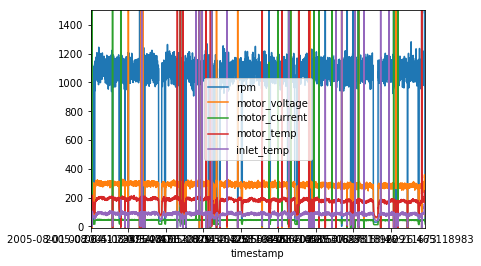

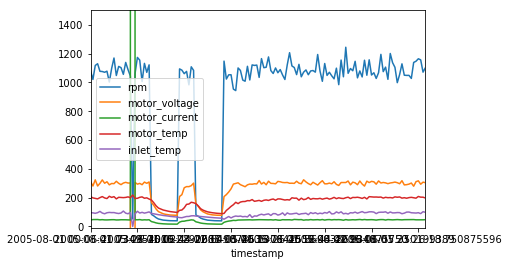

In [1]:
# To help you get started...
from IPython.display import display
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 

def load_rms(filename):
    return pd.read_csv(filename, index_col="timestamp")
def load_alarms(filename):
    return pd.read_csv(filename, header=None, names=["timestamp", "message"], index_col="timestamp").describe()

rms = load_rms('data/train/unit0000_rms.csv')
alarms = load_alarms('data/train/unit0000_alarms.csv')
rms.loc["2005-08-01":"2005-09-01"].plot(ylim=(-10, 1500))
rms.loc["2005-08-01":"2005-08-02"].plot(ylim=(-10, 1500))

display(rms.describe())
display(alarms.describe())

First of all I wanted to thank you for your good visualization and analysis which helped me to find a better way to start. As we are seeing in this summarization of data, we have a lot of noises in our data.

![title](pics/1.png)

Since we know that our data gathering system is noisy and antiquated due to the fact of communication problems, we can remove those noises by applying filters that cut off data points that are either higher than 99% or lower than 1% of our data range.

In [3]:
def reject_outliers(data, m=2):
    return data[abs(data - np.mean(data)) < m * np.std(data)]
filt_df = rms.loc[:, rms.columns != 'Index']
low = .01
high = .99
quant_df = filt_df.quantile([low, high])

filt_df = filt_df.apply(lambda x: x[(x>quant_df.loc[low,x.name]) & (x < quant_df.loc[high,x.name])], axis=0)
rms=filt_df

Now for same query as we had for a day and a month we will have something like this.

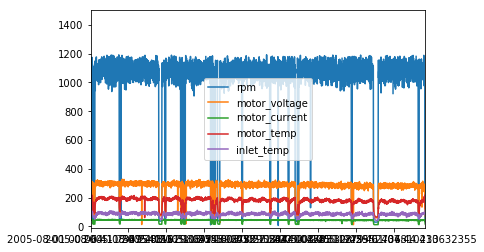

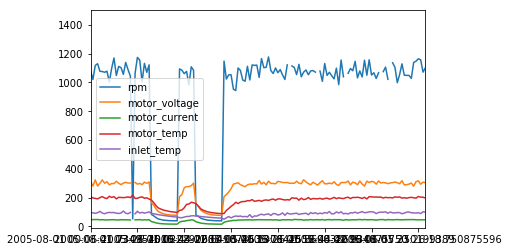

In [4]:
rms.loc["2005-08-01":"2005-09-01"].plot(ylim=(-10, 1500))
rms.loc["2005-08-01":"2005-08-02"].plot(ylim=(-10, 1500))

Now let's take a look into our data and see if our features have some correlation between them.

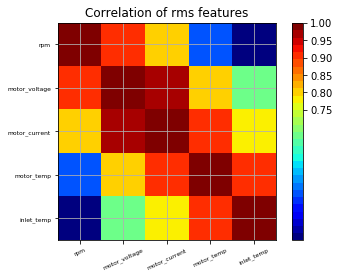

                    rpm  motor_voltage  motor_current  motor_temp  inlet_temp
rpm            1.000000       0.896891       0.803422    0.514538    0.376823
motor_voltage  0.896891       1.000000       0.969027    0.811091    0.673141
motor_current  0.803422       0.969027       1.000000    0.904153    0.773853
motor_temp     0.514538       0.811091       0.904153    1.000000    0.913664
inlet_temp     0.376823       0.673141       0.773853    0.913664    1.000000


In [5]:
from pandas import read_csv
def correlation_matrix(df):
    from matplotlib import pyplot as plt
    from matplotlib import cm as cm

    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    cmap = cm.get_cmap('jet', 30)
    cax = ax1.imshow(df.corr(), interpolation="nearest", cmap=cmap)
    ax1.grid(True)
    plt.title('Correlation of rms features')
    labels=['index','rpm','motor_voltage','motor_current','motor_temp','inlet_temp']
    ax1.set_xticklabels(labels,fontsize=6)
    ax1.set_yticklabels(labels,fontsize=6)
    fig.colorbar(cax, ticks=[.75,.8,.85,.90,.95,1])
    plt.xticks( rotation=25 )
    plt.show()
df = read_csv('data/train/unit0000_rms.csv')    
low = 0.01
high = .99
quant_df = df.quantile([low, high])

filt_df = filt_df.apply(lambda x: x[(x>quant_df.loc[low,x.name]) & (x < quant_df.loc[high,x.name])], axis=0)
ss=filt_df
    
correlation_matrix(ss)
print(ss.corr())

Okay as we expected we are seeing that based on Ohm's law(V=RI) our current is highly correlated with engine's voltage. Moreover, our temperature is very correlated to other features such as rpm and current which makes sense, when our engine is working it should have a higher temperature, but why rpm and voltage or current are not as highly correlated as maybe we expected? If we are looking into our data we are seeing that when current drops to the half our rpm would drop significantly from around 1100 to around ~40. That would be reasonable too because engines need specific current and voltage to start working and below that just won't work. Did we have to gather all of current, voltage and rpm together while they are highly correlated? Both yes and no, if we are working with very sensitive data and for some reason one of our sensors let's say current's sensor for any reason broke or couldn't work properly we can rebuild other current's samples by looking at voltage and rpm, but if it's not that important or we are not using that data anywhere that can be extra since it sends a lot of data over time.

Now we are going to take a look into alarms and rms files. As it's obvious our rms file has a better sampling per time over the limited time that matters to us(1 sample per ~10-20 minutes). However, for alarms file, we are having sometimes multiple records for one day and then nothing for days and weeks! So the question is WHY?! :/ 
For programming perspective, it would be nicer to have even time sapling so we could use them to forecast and make our model may be easier. But in general, since we are working with IOT devices I think it might not be that bad :-? Since our sampling technique would use a better energy saving pattern by not saving a lot of data and maybe also those gaps between our samples can show us something meaningful. One way to solve this problem is to do over-sampling. That would be good but since our data is so sparse in terms of weeks and months and we have a rule-based system that we don't know how it is working, so maybe adding data and upsampling would mislead our system to give false alarms! For now, we will leave this idea here.

Now let's do some analysis in python.

# Survival Method

Let's do a quick analysis on how much those 20 devices we would expect to work in terms of days. Since we are only interested in failure's of devices and we have their logs until they fail, so basically we don't have any censored or removed device in here.

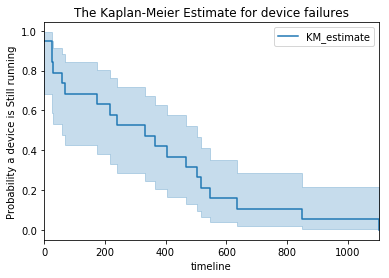

In [6]:

from pandas import read_csv
from pandas import datetime
from matplotlib import pyplot
from datetime import timedelta
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt
import pandas as pd

df1 = read_csv('data/train/unit0000_alarms.csv',header=None)
df2 = read_csv('data/train/unit0001_alarms.csv',header=None)
df3 = read_csv('data/train/unit0002_alarms.csv',header=None)
df4 = read_csv('data/train/unit0003_alarms.csv',header=None)
df5 = read_csv('data/train/unit0004_alarms.csv',header=None)
df6 = read_csv('data/train/unit0005_alarms.csv',header=None)
df7 = read_csv('data/train/unit0006_alarms.csv',header=None)
df8 = read_csv('data/train/unit0007_alarms.csv',header=None)
df9 = read_csv('data/train/unit0008_alarms.csv',header=None)
df10 = read_csv('data/train/unit0009_alarms.csv',header=None)
df11= read_csv('data/train/unit0010_alarms.csv',header=None)
df12 = read_csv('data/train/unit0011_alarms.csv',header=None)
df13 = read_csv('data/train/unit0012_alarms.csv',header=None)
df15= read_csv('data/train/unit0014_alarms.csv',header=None)
df16 = read_csv('data/train/unit0015_alarms.csv',header=None)
df17 = read_csv('data/train/unit0016_alarms.csv',header=None)
df18 = read_csv('data/train/unit0017_alarms.csv',header=None)
df19 = read_csv('data/train/unit0018_alarms.csv',header=None)
df20 = read_csv('data/train/unit0019_alarms.csv',header=None)
df1[0]=pd.to_datetime(df1[0])
df2[0]=pd.to_datetime(df2[0])
df3[0]=pd.to_datetime(df3[0])
df4[0]=pd.to_datetime(df4[0])
df5[0]=pd.to_datetime(df5[0])
df6[0]=pd.to_datetime(df6[0])
df7[0]=pd.to_datetime(df7[0])
df8[0]=pd.to_datetime(df8[0])
df9[0]=pd.to_datetime(df9[0])
df10[0]=pd.to_datetime(df10[0])
df11[0]=pd.to_datetime(df11[0])
df12[0]=pd.to_datetime(df12[0])
df13[0]=pd.to_datetime(df13[0])
df15[0]=pd.to_datetime(df15[0])
df16[0]=pd.to_datetime(df16[0])
df17[0]=pd.to_datetime(df17[0])
df18[0]=pd.to_datetime(df18[0])
df19[0]=pd.to_datetime(df19[0])


d1=(df1[0].max()-df1[0].min()).days
d2=(df2[0].max()-df2[0].min()).days
d3=(df3[0].max()-df3[0].min()).days
d4=(df4[0].max()-df4[0].min()).days
d5=(df5[0].max()-df5[0].min()).days
d6=(df6[0].max()-df6[0].min()).days
d7=(df7[0].max()-df7[0].min()).days
d8=(df8[0].max()-df8[0].min()).days
d9=(df9[0].max()-df9[0].min()).days
d10=(df10[0].max()-df10[0].min()).days
d11=(df11[0].max()-df11[0].min()).days
d12=(df12[0].max()-df12[0].min()).days
d13=(df13[0].max()-df13[0].min()).days
d15=(df15[0].max()-df15[0].min()).days
d16=(df16[0].max()-df16[0].min()).days
d17=(df17[0].max()-df17[0].min()).days
d18=(df18[0].max()-df18[0].min()).days
d19=(df19[0].max()-df19[0].min()).days
q=[]
q.append(d1)
q.append(d2)
q.append(d3)
q.append(d4)
q.append(d5)
q.append(d6)
q.append(d7)
q.append(d8)
q.append(d9)
q.append(d10)
q.append(d11)
q.append(d12)
q.append(d13)
q.append(d15)
q.append(d16)
q.append(d17)
q.append(d18)
q.append(d19)
final={'failed': [1, 1, 1, 1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1], 'duration': [634,173,29,849,332,503,1103,239,67,59,217,403,547,27,26,468,364,518,0]}
dff = pd.DataFrame(final)
kmf = KaplanMeierFitter()
kmf.fit(durations = dff.duration, 
        event_observed = dff.failed
)
kmf.plot()
plt.title("The Kaplan-Meier Estimate for device failures")
plt.ylabel("Probability a device is Still running")

So Technically we are seeing that we have sort of linear relation between our device age and its probability to work. The longer it's has been working the higher chance it gets to fail.

# LSTM

Now let's see what we can do we with neural networks. Firstly I tried to find a pattern in alarms files with NN and to see what would happen in future. There are some problems with this method. First of all, since our data is unevenly sampled we cannot use same usual methods, so we have to upsample our data. I used trace library to do that. Secondly, in our alarms file, we have sometimes collected data from one day on multiple records and sometimes we don't have any data for days, so after oversampling, we will lose data in those intervals that we have a lot and probably get irrelevant data in sparsely spaced intervals. I found an article that we can do some sort of analysis if we use Kalman filter since it would be good to transform and capture irregularly sampled data. Unfortunately, I hadn't time to go through it and implement that part on it. Then I tried to use LSTM network on rms files but how? I added some columns in our data which is showing how many more period of time(cycle) that device has to fail in future. By period of time I mean each of those intervals that we sampled our data. Since it's almost evenly spaced and those intervals are around 10-15 minutes I thought that would be good enough to work on it. Then I used another column(label1) to show whenever it's starting 30 days before device is going to fail. It's basically can be used to answer questions like if this device will fail in our considered time or not. It would be binary classification so 1 mean it will fail and 0 not. Then feeding to our LSTM network it would learn patterns that would lead to fail. I used window size of 30, so it would be around a day lag size and 30 days window to see if it fails in that period of time.

In [7]:
# -*- coding: utf-8 -*-
"""
Created on Wed Jun 13 17:44:00 2018

@author: Faraz
"""

import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# Setting seed for reproducibility
np.random.seed(1234)  
PYTHONHASHSEED = 0

from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout, LSTM
model_path = 'C:/C/internship/New folder/data-science-challenge-master/data/binary_model.h5'

train_df0 = pd.read_csv('data/train/unit0000_rms.csv')
train_df1 = pd.read_csv('data/train/unit0001_rms.csv')
train_df2 = pd.read_csv('data/train/unit0002_rms.csv')
train_df3 = pd.read_csv('data/train/unit0003_rms.csv')
train_df4 = pd.read_csv('data/train/unit0004_rms.csv')
train_df5 = pd.read_csv('data/train/unit0005_rms.csv')
train_df6 = pd.read_csv('data/train/unit0006_rms.csv')
train_df7 = pd.read_csv('data/train/unit0007_rms.csv')
train_df8 = pd.read_csv('data/train/unit0008_rms.csv')
train_df9 = pd.read_csv('data/train/unit0009_rms.csv')
train_df10 = pd.read_csv('data/train/unit0010_rms.csv')
train_df11 = pd.read_csv('data/train/unit0011_rms.csv')
train_df12 = pd.read_csv('data/train/unit0012_rms.csv')
train_df13 = pd.read_csv('data/train/unit0013_rms.csv')
train_df14 = pd.read_csv('data/train/unit0014_rms.csv')
train_df15 = pd.read_csv('data/train/unit0015_rms.csv')
train_df16 = pd.read_csv('data/train/unit0016_rms.csv')
train_df17 = pd.read_csv('data/train/unit0017_rms.csv')
train_df18 = pd.read_csv('data/train/unit0018_rms.csv')
train_df19 = pd.read_csv('data/train/unit0019_rms.csv')


test_df20 = pd.read_csv('data/test/unit0020_rms.csv')
test_df21 = pd.read_csv('data/test/unit0021_rms.csv')
test_df22 = pd.read_csv('data/test/unit0022_rms.csv')
test_df23 = pd.read_csv('data/test/unit0023_rms.csv')
test_df24 = pd.read_csv('data/test/unit0024_rms.csv')
test_df25 = pd.read_csv('data/test/unit0025_rms.csv')
test_df26 = pd.read_csv('data/test/unit0026_rms.csv')
test_df27 = pd.read_csv('data/test/unit0027_rms.csv')
test_df28 = pd.read_csv('data/test/unit0028_rms.csv')
test_df29 = pd.read_csv('data/test/unit0029_rms.csv')
test_df30 = pd.read_csv('data/test/unit0030_rms.csv')
test_df31 = pd.read_csv('data/test/unit0031_rms.csv')
test_df32 = pd.read_csv('data/test/unit0032_rms.csv')
test_df33 = pd.read_csv('data/test/unit0033_rms.csv')
test_df34 = pd.read_csv('data/test/unit0034_rms.csv')
test_df35 = pd.read_csv('data/test/unit0035_rms.csv')
test_df36 = pd.read_csv('data/test/unit0036_rms.csv')
test_df37 = pd.read_csv('data/test/unit0037_rms.csv')
test_df38 = pd.read_csv('data/test/unit0038_rms.csv')
test_df39 = pd.read_csv('data/test/unit0039_rms.csv')
test_df40 = pd.read_csv('data/test/unit0040_rms.csv')
test_df41 = pd.read_csv('data/test/unit0041_rms.csv')
test_df42 = pd.read_csv('data/test/unit0042_rms.csv')
test_df43 = pd.read_csv('data/test/unit0043_rms.csv')
test_df44 = pd.read_csv('data/test/unit0044_rms.csv')
test_df45 = pd.read_csv('data/test/unit0045_rms.csv')
test_df46 = pd.read_csv('data/test/unit0046_rms.csv')
test_df47 = pd.read_csv('data/test/unit0047_rms.csv')
test_df48 = pd.read_csv('data/test/unit0048_rms.csv')
test_df49 = pd.read_csv('data/test/unit0049_rms.csv')


train_df0['id']=0
train_df1['id']=1
train_df2['id']=2
train_df3['id']=3
train_df4['id']=4
train_df5['id']=5
train_df6['id']=6
train_df7['id']=7
train_df8['id']=8
train_df9['id']=9
train_df10['id']=10
train_df11['id']=11
train_df12['id']=12
train_df13['id']=13
train_df14['id']=14
train_df15['id']=15
train_df16['id']=16
train_df17['id']=17
train_df18['id']=18
train_df19['id']=19


test_df20['id']=20
test_df21['id']=21
test_df22['id']=22
test_df23['id']=23
test_df24['id']=24
test_df25['id']=25
test_df26['id']=26
test_df27['id']=27
test_df28['id']=28
test_df29['id']=29
test_df30['id']=30
test_df31['id']=31
test_df32['id']=32
test_df33['id']=33
test_df34['id']=34
test_df35['id']=35
test_df36['id']=36
test_df37['id']=37
test_df38['id']=38
test_df39['id']=39
test_df40['id']=40
test_df41['id']=41
test_df42['id']=42
test_df43['id']=43
test_df44['id']=44
test_df45['id']=45
test_df46['id']=46
test_df47['id']=47
test_df48['id']=48
test_df49['id']=49



train_df0['cycle']=train_df0.index+1
train_df1['cycle']=train_df1.index+1
train_df2['cycle']=train_df2.index+1
train_df3['cycle']=train_df3.index+1
train_df4['cycle']=train_df4.index+1
train_df5['cycle']=train_df5.index+1
train_df6['cycle']=train_df6.index+1
train_df7['cycle']=train_df7.index+1
train_df8['cycle']=train_df8.index+1
train_df9['cycle']=train_df9.index+1
train_df10['cycle']=train_df10.index+1
train_df11['cycle']=train_df11.index+1
train_df12['cycle']=train_df12.index+1
train_df13['cycle']=train_df13.index+1
train_df14['cycle']=train_df14.index+1
train_df15['cycle']=train_df15.index+1
train_df16['cycle']=train_df16.index+1
train_df17['cycle']=train_df17.index+1
train_df18['cycle']=train_df18.index+1
train_df19['cycle']=train_df19.index+1


test_df20['cycle']=test_df20.index+1
test_df21['cycle']=test_df21.index+1
test_df22['cycle']=test_df22.index+1
test_df23['cycle']=test_df23.index+1
test_df24['cycle']=test_df24.index+1
test_df25['cycle']=test_df25.index+1
test_df26['cycle']=test_df26.index+1
test_df27['cycle']=test_df27.index+1
test_df28['cycle']=test_df28.index+1
test_df29['cycle']=test_df29.index+1
test_df30['cycle']=test_df30.index+1
test_df31['cycle']=test_df31.index+1
test_df32['cycle']=test_df32.index+1
test_df33['cycle']=test_df33.index+1
test_df34['cycle']=test_df34.index+1
test_df35['cycle']=test_df35.index+1
test_df36['cycle']=test_df36.index+1
test_df37['cycle']=test_df37.index+1
test_df38['cycle']=test_df38.index+1
test_df39['cycle']=test_df39.index+1
test_df40['cycle']=test_df40.index+1
test_df41['cycle']=test_df41.index+1
test_df42['cycle']=test_df42.index+1
test_df43['cycle']=test_df43.index+1
test_df44['cycle']=test_df44.index+1
test_df45['cycle']=test_df45.index+1
test_df46['cycle']=test_df46.index+1
test_df47['cycle']=test_df47.index+1
test_df48['cycle']=test_df48.index+1
test_df49['cycle']=test_df49.index+1





rul={'id': [0, 1, 2, 3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19], 'max': [91715,26460,6671,124073,48125,75649,159982,34805,10224,10058,32153,58175,79175,1428,4711,6503,68435,53251,75193,24347]}
rul = pd.DataFrame(rul)

train_df = pd.concat([train_df0, train_df1,train_df2,train_df3,train_df4,train_df5,train_df6,train_df7,train_df8,train_df9,train_df10,train_df11,train_df12,train_df13,train_df14,train_df15,train_df16,train_df17,train_df18,train_df19])

train_df = train_df.merge(rul, on=['id'], how='left')

train_df['RUL'] = train_df['max'] - train_df['cycle']
train_df.drop('max', axis=1, inplace=True)
train_df.drop('timestamp', axis=1, inplace=True)


w1 = 30
w0 = 15
train_df['label1'] = np.where(train_df['RUL'] <= w1, 1, 0 )
train_df['label2'] = train_df['label1']
train_df.loc[train_df['RUL'] <= w0, 'label2'] = 2

train_df['cycle_norm'] = train_df['cycle']
cols_normalize = train_df.columns.difference(['id','cycle','RUL','label1','label2'])
train_df.fillna(0, inplace=True)
min_max_scaler = preprocessing.MinMaxScaler()
norm_train_df = pd.DataFrame(min_max_scaler.fit_transform(train_df[cols_normalize]), 
                             columns=cols_normalize, 
                             index=train_df.index)



join_df = train_df[train_df.columns.difference(cols_normalize)].join(norm_train_df)
train_df = join_df.reindex(columns = train_df.columns)




rul={'id': [20, 21, 22, 23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49], 'max': [4465,4465,4465,4465,4465,4465,4465,4465,4465,4465,4465,4465,4465,4465,4465,4465,4465,4465,4465,4465,4465,4465,4465,4465,4465,4465,4465,4465,4465,4465]}
rul = pd.DataFrame(rul)

test_df = pd.concat([test_df20, test_df21,test_df22,test_df23,test_df24,test_df25,test_df26,test_df27,test_df28,test_df29,test_df30,test_df31,test_df32,test_df33,test_df34,test_df35,test_df36,test_df37,test_df38,test_df39,test_df40,test_df41,test_df42,test_df43,test_df44,test_df45,test_df46,test_df47,test_df48,test_df49])
test_df = test_df.merge(rul, on=['id'], how='left')
test_df['RUL'] = test_df['max'] - test_df['cycle']
test_df.drop('max', axis=1, inplace=True)
test_df.drop('timestamp', axis=1, inplace=True)

w1 = 30
w0 = 15
test_df['label1'] = np.where(test_df['RUL'] <= w1, 1, 0 )
test_df['label2'] = test_df['label1']
test_df.loc[test_df['RUL'] <= w0, 'label2'] = 2

test_df['cycle_norm'] = test_df['cycle']
cols_normalize = test_df.columns.difference(['id','cycle','RUL','label1','label2'])
test_df.fillna(0, inplace=True)
min_max_scaler = preprocessing.MinMaxScaler()
norm_test_df = pd.DataFrame(min_max_scaler.fit_transform(test_df[cols_normalize]), 
                             columns=cols_normalize, 
                             index=test_df.index)


join_df = test_df[test_df.columns.difference(cols_normalize)].join(norm_test_df)
test_df = join_df.reindex(columns = test_df.columns)


#===============LSTM




sequence_length = 30


def gen_sequence(id_df, seq_length, seq_cols):
    
    data_matrix = id_df[seq_cols].values
    num_elements = data_matrix.shape[0]
    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        yield data_matrix[start:stop, :]
        
sequence_cols = ['rpm', 'motor_voltage', 'motor_current','motor_temp','inlet_temp', 'cycle_norm']

seq_gen = (list(gen_sequence(train_df[train_df['id']==id], sequence_length, sequence_cols)) 
           for id in train_df['id'].unique())

seq_array = np.concatenate(list(seq_gen)).astype(np.float32)





def gen_labels(id_df, seq_length, label):
    data_matrix = id_df[label].values
    num_elements = data_matrix.shape[0]
    return data_matrix[seq_length:num_elements, :]

label_gen = [gen_labels(train_df[train_df['id']==id], sequence_length, ['label1']) 
             for id in train_df['id'].unique()]
label_array = np.concatenate(label_gen).astype(np.float32)




nb_features = seq_array.shape[2]
nb_out = label_array.shape[1]

model = Sequential()
model.add(LSTM(
         input_shape=(sequence_length, nb_features),
         units=100,
         return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(
          units=50,
          return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(units=nb_out, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


history = model.fit(seq_array, label_array, epochs=2, batch_size=2000, validation_split=0.05, verbose=2,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'),
                       keras.callbacks.ModelCheckpoint(model_path,monitor='val_loss', save_best_only=True, mode='min', verbose=0)]
          )



scores = model.evaluate(seq_array, label_array, verbose=1, batch_size=200)
print('Accurracy: {}'.format(scores[1]))

y_pred = model.predict_classes(seq_array,verbose=1, batch_size=200)
y_true = label_array

test_set = pd.DataFrame(y_pred)
test_set.to_csv('data/binary_submit_train.csv', index = None)

print('Confusion matrix\n- x-axis is true labels.\n- y-axis is predicted labels')
cm = confusion_matrix(y_true, y_pred)
print(cm)

precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
print( 'precision = ', precision, '\n', 'recall = ', recall)


seq_array_test_last = [test_df[test_df['id']==id][sequence_cols].values[-sequence_length:] 
                       for id in test_df['id'].unique() if len(test_df[test_df['id']==id]) >= sequence_length]

seq_array_test_last = np.asarray(seq_array_test_last).astype(np.float32)


y_mask = [len(test_df[test_df['id']==id]) >= sequence_length for id in test_df['id'].unique()]

label_array_test_last = test_df.groupby('id')['label1'].nth(-1)[y_mask].values
label_array_test_last = label_array_test_last.reshape(label_array_test_last.shape[0],1).astype(np.float32)


if os.path.isfile(model_path):
    estimator = load_model(model_path)

scores_test = estimator.evaluate(seq_array_test_last, label_array_test_last, verbose=2)
print('Accurracy: {}'.format(scores_test[1]))

y_pred_test = estimator.predict_classes(seq_array_test_last)
y_true_test = label_array_test_last

test_set = pd.DataFrame(y_pred_test)
test_set.to_csv('data/binary_submit_test.csv', index = None)

print('Confusion matrix\n- x-axis is true labels.\n- y-axis is predicted labels')
cm = confusion_matrix(y_true_test, y_pred_test)
print(cm)

precision_test = precision_score(y_true_test, y_pred_test)
recall_test = recall_score(y_true_test, y_pred_test)
f1_test = 2 * (precision_test * recall_test) / (precision_test + recall_test)
print( 'Precision: ', precision_test, '\n', 'Recall: ', recall_test,'\n', 'F1-score:', f1_test )


Using TensorFlow backend.


Train on 940056 samples, validate on 49477 samples
Epoch 1/2
 - 361s - loss: 0.0119 - acc: 0.9993 - val_loss: 0.0102 - val_acc: 0.9987
Epoch 2/2
 - 352s - loss: 0.0049 - acc: 0.9994 - val_loss: 0.0101 - val_acc: 0.9987
989533/989533 [==============================] - 152s 153us/step
Accurracy: 0.9994047698281322
989533/989533 [==============================] - 152s 154us/step
Confusion matrix
- x-axis is true labels.
- y-axis is predicted labels
[[988944      0]
 [   589      0]]


c:\users\faraz\anaconda2\envs\36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


precision =  0.0 
 recall =  0.0
Accurracy: 0.03333333507180214
Confusion matrix
- x-axis is true labels.
- y-axis is predicted labels
[[ 1  0]
 [29  0]]
Precision:  0.0 
 Recall:  0.0 
 F1-score: nan


After running this LSTM network we will get a file in data folder with name of binary_submit_train/test to see what would be answer. Unfourtuneyl since it's a very time consuming network and computationally heavy process I couldn't try different hyperparameters for my network to see what would be good reasonable fit to answer our questions. That's why I set epochs in 2, but still that's a deep network and a lot of data. it seems that with these features it cannot predict correctly or maybe none of those test data would fail in 30 days, but I guess the total concept of process is making sense since we are giving our network those parameters that we care to predict and then by feeding our features it would learn and it can make a binary classification based on those learned patterns. From looking at those logged files I would say it shouldn't be needed to look at a window of more than a month at most and a day at least. probably something combined which means the combination of those events would show a failure pattern or with higher probability I'd say the recent pattern of working in our engine would be enough to predict future and by recent I mean maybe few days. In general, I guess playing with those hyperparameters like window size(label) and related LSTM parameters we would get a better network with correct prediction results. I wish I had solution that you removed from git to give you correct answer :D. Thank you so much for reading this and giving me time to work on it. It was a very fun and informative project. If you had any question regarding my notebook I will be more than happy to answer.